# 23年碳排放数据重采样提取202308-202312

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.3f}'.format)
import warnings
warnings.filterwarnings("ignore")
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题


In [5]:
#输入碳排放数据月文件路径，合并为整年并重采样计算日度数据（碳排放强度均值）
def get_emission_rate_23(directory):#emssion_data_directory
    # List to hold each DataFrame
    dataframes = []
    # Loop through all files in the directory
    for file in os.listdir(directory): 
        print(file)#打印该路径下读取到的文件名
        # Construct full file path
        file_path = os.path.join(directory, file)
        # Read the Excel file into a DataFrame
        df = pd.read_excel(file_path,skiprows=1).iloc[::,2:]
        # Append the DataFrame to the list
        dataframes.append(df)
        #print(df)
    # Concatenate all DataFrames into df for one year 
    year_df = pd.concat(dataframes, ignore_index=True)
    
    # convert date from object type to datetime type 
    year_df['时间'] = pd.to_datetime(year_df['时间'])
    # set date to index
    year_df.set_index('时间', inplace=True)
    # sort data by date
    year_df = year_df.sort_index()

    #选择全年非停机数据
    year_df_without0 = year_df[year_df["负荷"] != 0]
    #计算5mins 间隔的 碳排放强度
    year_df_without0["碳排放强度"] = ( (year_df_without0["二氧化碳"]*44/22.4*10000)/1000*year_df_without0["烟气流量"] ) / (1000 * year_df_without0["负荷"])

    # resample to daily data
    daily_data = year_df_without0.resample('D').agg({
        '负荷': 'mean',  # 计算每日平均负荷
        '二氧化碳': 'mean',  # 计算每日二氧化碳体积浓度平均值
        '氧含量(%)': 'mean',  # 计算每日平均氧含量
        '烟气流量': 'mean',   # 计算每日平均烟气流量
        '碳排放量': 'sum',    # 计算每日碳排放量总和
        '碳排放强度': 'mean'   # 由5mins碳排放强度计算每日碳排放量均值
    })
    daily_emssion = daily_data[(daily_data["碳排放强度"] != 0) & (daily_data["碳排放强度"].notnull())]
    return daily_emssion


In [2]:
    
directory_1_23 = '../data/皖能马鞍山一号机组碳排放监测数据/1号机组碳排放监测数据202308-202412/1号机组碳排放监测数据202308-202312'
daily_df_1_23 = get_emission_rate_23(directory_1_23)
daily_df_1_23 = daily_df_1_23.reset_index()
daily_df_1_23
#202308-202312应为153天数据 实际128天 是由于107C检修606小时约为25天导致 （2023/11/16 0:49-2023/12/11 7:28）

皖能马鞍山一号机组23年10月.xlsx
皖能马鞍山一号机组23年11月.xlsx
皖能马鞍山一号机组23年12月.xlsx
皖能马鞍山一号机组23年8月.xlsx
皖能马鞍山一号机组23年9月.xlsx


,时间,负荷,二氧化碳,氧含量(%),烟气流量,碳排放量,碳排放强度
0,2023-08-01,389.677,11.324,5.859,1528143.490,8268.340,874.946
1,2023-08-02,408.276,11.329,5.875,1574934.471,8555.600,860.640
2,2023-08-03,405.237,11.385,5.803,1587287.548,8688.890,880.362
3,2023-08-04,553.981,12.082,4.694,1967935.960,11505.780,857.798
4,2023-08-05,616.803,12.420,4.280,2154637.770,12827.240,853.046
...,...,...,...,...,...,...,...
123,2023-12-27,419.167,10.907,6.301,1436318.729,7532.080,740.159
124,2023-12-28,497.384,11.345,5.729,1589647.482,8714.950,726.002
125,2023-12-29,572.455,11.693,5.186,1762529.724,9816.460,715.157
126,2023-12-30,487.565,11.382,5.800,1588483.945,8675.050,734.314


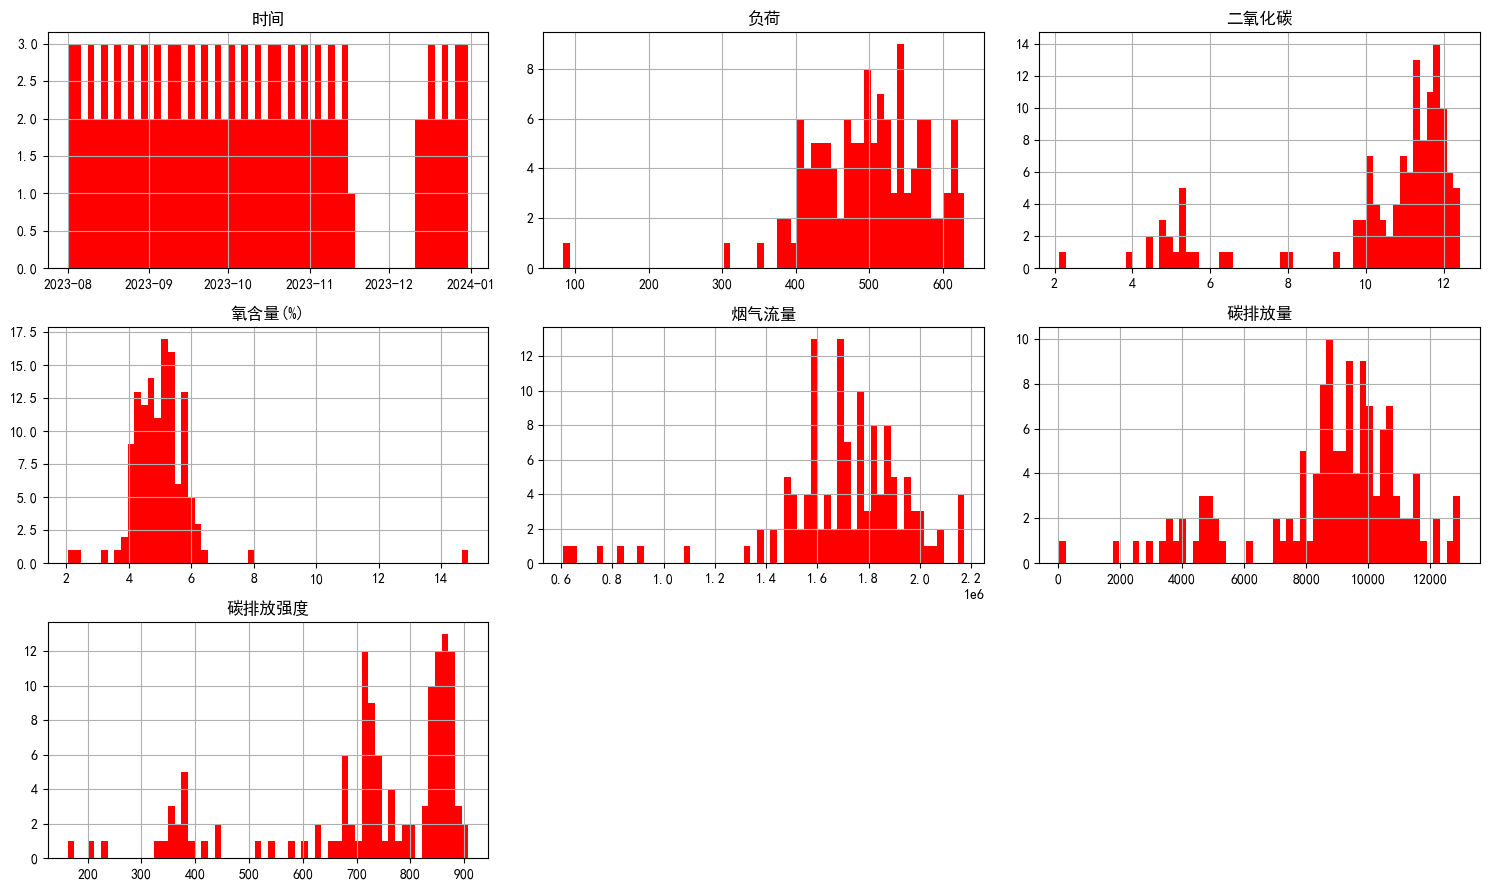

In [6]:
daily_df_1_23.hist(bins=60, figsize=(15,9),color="red");plt.tight_layout();plt.show()

In [3]:
df23 = daily_df_1_23[["时间","负荷","碳排放强度"]]
df23

,时间,负荷,碳排放强度
0,2023-08-01,389.677,874.946
1,2023-08-02,408.276,860.640
2,2023-08-03,405.237,880.362
3,2023-08-04,553.981,857.798
4,2023-08-05,616.803,853.046
...,...,...,...
123,2023-12-27,419.167,740.159
124,2023-12-28,497.384,726.002
125,2023-12-29,572.455,715.157
126,2023-12-30,487.565,734.314


# 24年碳排放数据重采样提取202401-202412

## 函数直接返回有效值（Ryan）

In [36]:

#输入碳排放数据月文件路径，合并为整年并重采样计算日度数据（碳排放强度均值）
def get_emission_rate_24(directory):#emssion_data_directory
    # List to hold each DataFrame
    dataframes = []
    # Loop through all files in the directory
    for file in os.listdir(directory): 
        #When an excel file is opened for example by MS excel a hidden temporary file is created in the same directory:~$神皖安庆一号机组23年1月.xlsx
        if not file.startswith("~") and file.endswith('.xlsx'):
            print(file)#打印该路径下读取到的文件名
            # Construct full file path
            file_path = os.path.join(directory, file)
            # Read the Excel file into a DataFrame
            df = pd.read_excel(file_path,skiprows=1).iloc[::,2:]
            #转换数据格式 obj——>float 以运算
            df['排放量绩效平均值(g/kwh)'] = pd.to_numeric(df['排放量绩效平均值(g/kwh)'], errors='coerce')
            # Append the DataFrame to the list
            dataframes.append(df)
            #print(df)
    # Concatenate all DataFrames into df for one year 
    year_df = pd.concat(dataframes, ignore_index=True)
    
    # convert date from object type to datetime type 
    year_df['时间'] = pd.to_datetime(year_df['时间'])
    # set date to index
    year_df.set_index('时间', inplace=True)
    # sort data by date
    year_df = year_df.sort_index()

    #选择全年非停机数据
    year_df_without0 = year_df[year_df["有功功率平均值(MW)"] != 0]
    #计算5mins 间隔的 碳排放强度
    year_df_without0["碳排放强度"] = ( (year_df_without0["C02浓度平均值(%)"]*44/22.4*10000)/1000*year_df_without0["烟气流量平均值(dNm3/h)"] ) / (1000 * year_df_without0["有功功率平均值(MW)"])

    # resample to daily data
    daily_data = year_df_without0.resample('D').agg({
        '有功功率平均值(MW)': 'mean',
        '负荷率平均值(%)': 'mean',
        'C02浓度平均值(%)': 'mean',
        '氧含量平均值(%)': 'mean',
        '烟气流量平均值(dNm3/h)': 'mean',
        '碳排放量五分钟累计值(t)': 'sum' ,
        '排放量绩效平均值(g/kwh)': 'mean',
        '碳排放强度': 'mean'
    })
    daily_emssion = daily_data[(daily_data["碳排放强度"] != 0) & (daily_data["碳排放强度"].notnull())]
    return daily_emssion.reset_index()


In [37]:
directory_1_24 = '../data/皖能马鞍山一号机组碳排放监测数据/1号机组碳排放监测数据202308-202412/1号机组碳排放监测数据202401-202412'
daily_df_1_24 = get_emission_rate_24(directory_1_24)
daily_df_1_24

马鞍山一号机组-24年10月.xlsx
马鞍山一号机组-24年11月.xlsx
马鞍山一号机组-24年12月.xlsx
马鞍山一号机组-24年1月.xlsx
马鞍山一号机组-24年2月.xlsx
马鞍山一号机组-24年3月.xlsx
马鞍山一号机组-24年4月.xlsx
马鞍山一号机组-24年5月.xlsx
马鞍山一号机组-24年6月.xlsx
马鞍山一号机组-24年7月.xlsx
马鞍山一号机组-24年8月.xlsx
马鞍山一号机组-24年9月.xlsx


,时间,有功功率平均值(MW),负荷率平均值(%),C02浓度平均值(%),氧含量平均值(%),烟气流量平均值(dNm3/h),碳排放量五分钟累计值(t),排放量绩效平均值(g/kwh),碳排放强度
0,2024-01-01,392.596,59.484,10.625,7.211,1388990.264,6856.150,732.814,750.398
1,2024-01-02,612.838,92.854,12.156,4.610,1834224.158,9588.590,690.372,715.309
2,2024-01-03,614.009,93.032,12.130,4.673,1869621.403,10638.840,723.187,726.765
3,2024-01-04,435.709,66.016,10.712,6.798,1489550.704,7566.730,757.025,787.900
4,2024-01-05,432.340,65.506,10.938,6.399,1461719.123,6313.160,594.165,733.268
...,...,...,...,...,...,...,...,...,...
274,2024-12-27,513.772,77.844,11.980,0.409,1720474.551,9277.240,748.278,794.480
275,2024-12-28,377.355,57.175,10.681,4.861,1418891.640,6521.090,721.144,795.349
276,2024-12-29,360.441,54.612,11.779,0.438,1384880.834,4819.200,557.622,896.681
277,2024-12-30,351.485,53.255,11.738,0.455,1366240.674,3077.580,362.188,897.858


In [1]:
daily_df_1_24[daily_df_1_24["碳排放量五分钟累计值(t)"<264]]

NameError: name 'daily_df_1_24' is not defined

## 导入返回含维修（NaN值）有效值（jxd）

In [39]:
import pandas as pd
import os

pd.set_option('display.float_format', '{:.3f}'.format)
dataframes = []
# Specify the directory containing the Excel files
directory = '../data/皖能马鞍山一号机组碳排放监测数据/1号机组碳排放监测数据202308-202412/1号机组碳排放监测数据202401-202412'
# Loop through all files in the directory
for file in os.listdir(directory):
    print(file)#打印该路径下读取到的文件名
    file_path = os.path.join(directory, file)
    df = pd.read_excel(file_path,skiprows=1).iloc[::,2:]

    #转换数据格式 obj——>float 以运算
    df['排放量绩效平均值(g/kwh)'] = pd.to_numeric(df['排放量绩效平均值(g/kwh)'], errors='coerce')

    #选择非停机数据
    df_without0 = df[df["负荷率平均值(%)"] != 0]
    #计算5mins 间隔的 碳排放强度
    df_without0["碳排放强度"] = ( (df_without0["C02浓度平均值(%)"]*44/22.4*10000)/1000*df_without0["烟气流量平均值(dNm3/h)"] ) / (1000 * df_without0["有功功率平均值(MW)"])
    #convert to datetime datatype
    df_without0['时间'] = pd.to_datetime(df_without0['时间'])
    # set date to index
    df_without0.set_index('时间', inplace=True)
    # resample to daily data
    daily = df_without0.resample('d').agg({
        '有功功率平均值(MW)': 'mean',
        '负荷率平均值(%)': 'mean',
        'C02浓度平均值(%)': 'mean',
        '氧含量平均值(%)': 'mean',
        '烟气流量平均值(dNm3/h)': 'mean',
        '碳排放量五分钟累计值(t)': 'sum' ,
        '排放量绩效平均值(g/kwh)': 'mean',
        '碳排放强度': 'mean'
    })
    dataframes.append(daily)
year_df = pd.concat(dataframes)
year_df = year_df.sort_index()
year_df = year_df.reset_index()
# year_df = year_df[(year_df["碳排放强度"] != 0) & (year_df["碳排放强度"].notnull()) ]


马鞍山一号机组-24年10月.xlsx
马鞍山一号机组-24年11月.xlsx
马鞍山一号机组-24年12月.xlsx
马鞍山一号机组-24年1月.xlsx
马鞍山一号机组-24年2月.xlsx
马鞍山一号机组-24年3月.xlsx
马鞍山一号机组-24年4月.xlsx
马鞍山一号机组-24年5月.xlsx
马鞍山一号机组-24年6月.xlsx
马鞍山一号机组-24年7月.xlsx
马鞍山一号机组-24年8月.xlsx
马鞍山一号机组-24年9月.xlsx


In [40]:
year_df

,时间,有功功率平均值(MW),负荷率平均值(%),C02浓度平均值(%),氧含量平均值(%),烟气流量平均值(dNm3/h),碳排放量五分钟累计值(t),排放量绩效平均值(g/kwh),碳排放强度
0,2024-01-01,392.596,59.484,10.625,7.211,1388990.264,6856.150,732.814,750.398
1,2024-01-02,612.838,92.854,12.156,4.610,1834224.158,9588.590,690.372,715.309
2,2024-01-03,614.009,93.032,12.130,4.673,1869621.403,10638.840,723.187,726.765
3,2024-01-04,435.709,66.016,10.712,6.798,1489550.704,7566.730,757.025,787.900
4,2024-01-05,432.340,65.506,10.938,6.399,1461719.123,6313.160,594.165,733.268
...,...,...,...,...,...,...,...,...,...
288,2024-12-27,513.772,77.844,11.980,0.409,1720474.551,9277.240,748.278,794.480
289,2024-12-28,377.355,57.175,10.681,4.861,1418891.640,6521.090,721.144,795.349
290,2024-12-29,360.441,54.612,11.779,0.438,1384880.834,4819.200,557.622,896.681
291,2024-12-30,351.485,53.255,11.738,0.455,1366240.674,3077.580,362.188,897.858


In [41]:
year_df[year_df['碳排放强度'] == 0]

,时间,有功功率平均值(MW),负荷率平均值(%),C02浓度平均值(%),氧含量平均值(%),烟气流量平均值(dNm3/h),碳排放量五分钟累计值(t),排放量绩效平均值(g/kwh),碳排放强度


In [42]:
#维修或故障无数据
year_df[year_df['碳排放强度'].isnull()]

,时间,有功功率平均值(MW),负荷率平均值(%),C02浓度平均值(%),氧含量平均值(%),烟气流量平均值(dNm3/h),碳排放量五分钟累计值(t),排放量绩效平均值(g/kwh),碳排放强度
43,2024-02-13,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
44,2024-02-14,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
45,2024-02-15,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
46,2024-02-16,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
47,2024-02-17,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
48,2024-02-18,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
164,2024-06-21,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
165,2024-06-22,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
166,2024-06-23,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN
167,2024-06-24,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN


In [43]:
293-14

279

In [44]:
df24 = year_df[["时间","有功功率平均值(MW)","碳排放强度"]]
df24.columns = ["时间","负荷","碳排放强度"]
df24

,时间,负荷,碳排放强度
0,2024-01-01,392.596,750.398
1,2024-01-02,612.838,715.309
2,2024-01-03,614.009,726.765
3,2024-01-04,435.709,787.900
4,2024-01-05,432.340,733.268
...,...,...,...
288,2024-12-27,513.772,794.480
289,2024-12-28,377.355,795.349
290,2024-12-29,360.441,896.681
291,2024-12-30,351.485,897.858


In [12]:
293+128

421

# 2324年碳排放数据合并 并补充缺失日期202308-202412

In [45]:
emission = pd.concat([df23,df24])
#加入负荷率列
emission["负荷率"] = emission["负荷"]/660 * 100
emission

,时间,负荷,碳排放强度,负荷率
0,2023-08-01,389.677,874.946,59.042
1,2023-08-02,408.276,860.640,61.860
2,2023-08-03,405.237,880.362,61.400
3,2023-08-04,553.981,857.798,83.936
4,2023-08-05,616.803,853.046,93.455
...,...,...,...,...
288,2024-12-27,513.772,794.480,77.844
289,2024-12-28,377.355,795.349,57.175
290,2024-12-29,360.441,896.681,54.612
291,2024-12-30,351.485,897.858,53.255


In [46]:
emission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421 entries, 0 to 292
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   时间      421 non-null    datetime64[ns]
 1   负荷      407 non-null    float64       
 2   碳排放强度   407 non-null    float64       
 3   负荷率     407 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 16.4 KB


In [47]:
# 生成完整的日期范围
start_date = emission['时间'].min()  # 获取最小日期
end_date = emission['时间'].max()    # 获取最大日期
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 创建一个包含所有日期的 DataFrame
df_full = pd.DataFrame({'时间': date_range})

# 合并原始 DataFrame 和完整日期 DataFrame
df_all = pd.merge(df_full, emission, on='时间', how='left')

# 输出结果查看
df_all


,时间,负荷,碳排放强度,负荷率
0,2023-08-01,389.677,874.946,59.042
1,2023-08-02,408.276,860.640,61.860
2,2023-08-03,405.237,880.362,61.400
3,2023-08-04,553.981,857.798,83.936
4,2023-08-05,616.803,853.046,93.455
...,...,...,...,...
514,2024-12-27,513.772,794.480,77.844
515,2024-12-28,377.355,795.349,57.175
516,2024-12-29,360.441,896.681,54.612
517,2024-12-30,351.485,897.858,53.255


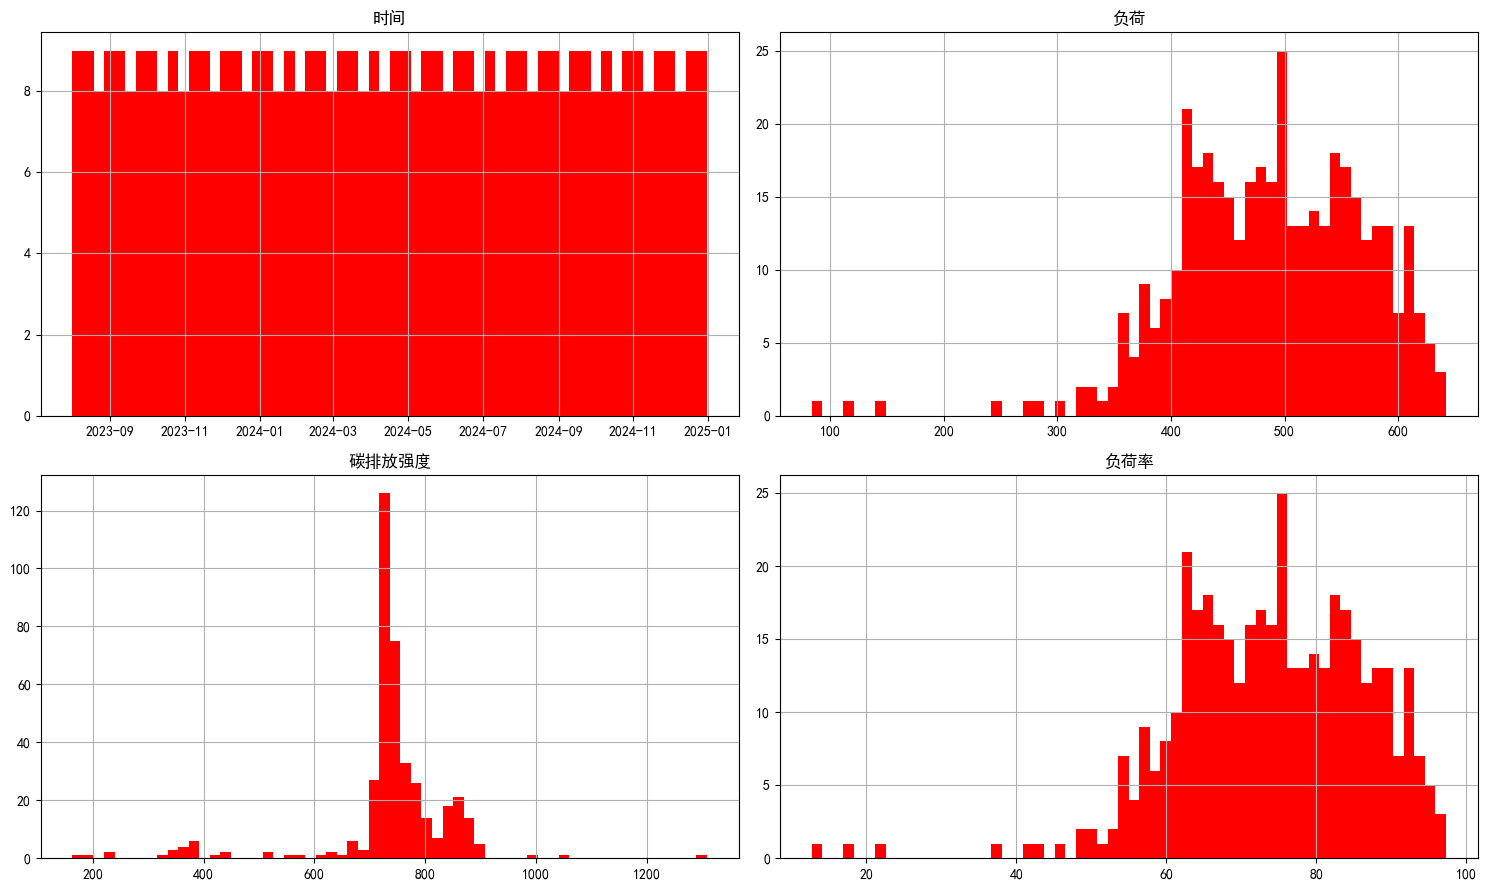

In [48]:
df_all.hist(bins=60, figsize=(15,9),color="red");plt.tight_layout();plt.show()

In [51]:
df_all.to_excel("../已提取数据/马鞍山1号碳排放监测数据202308-202412.xlsx",index = False)